Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from itertools import chain, combinations

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [2]:
print(device)

cpu


Handling Data

In [3]:
data = torch.load('fsd.pth')

C:\Users\aniru\AppData\Local\Temp\ipykernel_12964\2533101342.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('fsd.pth')


In [4]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_lbls, test_lbls = train_test_split(data['images'], data['labels'], test_size = 0.4)
val_imgs, test_imgs, val_lbls, test_lbls = train_test_split(test_imgs, test_lbls, test_size = 0.5)

print(f"{data['images'].shape}")
print(f"train: {train_imgs.shape}, val: {val_imgs.shape}, test: {test_imgs.shape}")
print(f"train: {train_lbls.shape}, val: {val_lbls.shape}, test: {test_lbls.shape}")

torch.Size([2000, 3, 512, 512])
train: torch.Size([1200, 3, 512, 512]), val: torch.Size([400, 3, 512, 512]), test: torch.Size([400, 3, 512, 512])
train: torch.Size([1200, 200]), val: torch.Size([400, 200]), test: torch.Size([400, 200])


In [5]:
data = None

In [6]:
class EpisodicDataset():
    def __init__(self, data, lbls):
        self.data = data
        self.lbls = lbls
        self.num_classes = lbls.shape[1]

        # create dictionary where each class holds all indices of data part of that class
        self.class_indices = {
          c: torch.where(self.lbls[:, c] == 1)[0]
          for c in range(self.num_classes)
        }

    def getEpisode(self, min_n_way, try_k_shot, try_n_query):
        # Choose random subset of n_way classes

        valid_classes = [
          c for c, indices in self.class_indices.items()
          if len(indices) >= try_k_shot + try_n_query
        ]
        if len(valid_classes) < min_n_way:
          raise ValueError(f"critical: try_k_shot + try_n_query is too big or min_n_way is too big, there are {len(valid_classes)} valid classes")

        selected_classes = random.choices(valid_classes, k=min_n_way)

        support_indices = set()
        query_indices = set()

        for c in selected_classes:
          indices = self.class_indices[c]
          selected_indices = indices[torch.randperm(len(indices))][:try_k_shot + try_n_query]
          support_indices.update(selected_indices[:try_k_shot].tolist())
          query_indices.update(selected_indices[try_k_shot:].tolist())

        # remove overlap
        query_indices.difference_update(support_indices)

        support_indices = torch.tensor(list(support_indices), dtype=torch.long)
        query_indices = torch.tensor(list(query_indices), dtype=torch.long)

        return {
            'support_data': self.data[support_indices], # (~n_way * ~k_shot, C, H, W)
            'support_label': self.lbls[support_indices], # (~n_way * ~k_shot, num_classes)
            'query_data': self.data[query_indices], # (~n_way * ~n_query, C, H, W)
            'query_label': self.lbls[query_indices] # (~n_way * ~n_query, num_classes)
        }

train_dataset = EpisodicDataset(train_imgs, train_lbls)

In [7]:
episode = train_dataset.getEpisode(5, 5, 5)
print(f"{episode['support_data'].shape}, {episode['support_label'].shape}, {episode['query_data'].shape}, {episode['query_label'].shape}")

torch.Size([25, 3, 512, 512]), torch.Size([25, 200]), torch.Size([25, 3, 512, 512]), torch.Size([25, 200])


CNN stuff

In [8]:
def l2_regularization(model, lambda_l2=1e-4):
    l2_norm = 0
    for param in model.parameters():
        l2_norm += param.pow(2).sum()
    return lambda_l2 * l2_norm

class ConvEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    def conv_block(in_channel, out_channel):
      return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(),
        nn.Dropout2d(p=0.2),
        nn.MaxPool2d(2)
      )
    
    self.encoder = nn.Sequential(
      conv_block(3, 64), # 512 -> 256
      conv_block(64, 64), # 256 -> 128
      conv_block(64, 64), # 128 -> 64
      conv_block(64, 128), # 64 -> 32
      conv_block(128, 256), # 32 -> 16
      conv_block(256, 512), # 16 -> 8
    )

    self.fc = nn.Linear(512, 64)

  def forward(self, x):
    x = self.encoder(x) # batch_size, 256, 8, 8
    return x

ProtoNet stuff

In [9]:
def euclidean_dist(x, y):
  n_class, n_sample, n_feature = y.shape[0], x.shape[0], x.shape[1]

  x = x.unsqueeze(1).expand(-1, n_class, -1)
  y = y.unsqueeze(0).expand(n_sample, -1, -1)

  return torch.pow(x - y, 2).sum(2)

In [10]:
def prototypical_loss(model, episode, device):
  model.train()
  model.to(device)

  # create extended vector of labels for each support and query
  num_classes = episode['support_label'].shape[1]

  unique_combinations = set()
  for label_set in episode['support_label']:
      active = tuple(i for i, val in enumerate(label_set) if val == 1)
      if active:
          unique_combinations.add(active)
  for label_set in episode['query_label']:
      active = tuple(i for i, val in enumerate(label_set) if val == 1)
      if active:
          unique_combinations.add(active)

  def get_power_set(indices):
    s = list(indices)
    return list(chain.from_iterable(combinations(s, r) for r in range(1, len(s) + 1)))

  all_subsets = set()
  for idx_comb in unique_combinations:
    for subsets in get_power_set(idx_comb):
      all_subsets.add(tuple(sorted(subsets)))

  all_subsets = sorted(all_subsets, key=lambda s: (len(s), s))
  subset_map = {subset: i for i, subset in enumerate(all_subsets)} # subset tuple to idx in extended multi hot encoded

  def extend_labels(labels):
    ext = torch.zeros((len(labels), len(all_subsets)), dtype=torch.int, device=device)
    for i, row in enumerate(labels):
      active_indices = tuple(sorted(j for j, val in enumerate(row) if val == 1))
      if active_indices:
        for subset in get_power_set(active_indices):
          subset = tuple(sorted(subset))
          ext[i, subset_map[subset]] = 1
    return ext

  support_ext_lbls = extend_labels(episode['support_label'])
  query_ext_lbls = extend_labels(episode['query_label'])

  # calculate prototype for each label combination
  support_embeddings = model(episode['support_data'].to(device)) # n_way
  query_embeddings = model(episode['query_data'].to(device))
  d = support_embeddings.shape[1]
  num_proto = len(all_subsets)
  prototypes = torch.zeros((num_proto, d), device=device)
  counts = torch.zeros(num_proto, device=device)

  for i in range(support_embeddings.shape[0]):
      active_prototypes = support_ext_lbls[i].nonzero(as_tuple=True)[0]
      for p in active_prototypes:
          prototypes[p] += support_embeddings[i]
          counts[p] += 1
  counts = counts.clamp(min=1)
  prototypes /= counts.unsqueeze(1)  # Compute mean embeddings

  # Compute distances between query embeddings and prototypes
  distances = euclidean_dist(query_embeddings, prototypes)  # Shape: (num_query, num_subsets)

  # Apply sigmoid and compute loss using BCE
  #print(distances.shape)
  #print(query_ext_lbls.float().shape)
  pos_freq = query_ext_lbls.float().mean(dim=0)
  epsilon = 1e-6
  raw_pos_weight = 1.0 / (pos_freq + epsilon)
  max_weight = 10.0
  pos_weight  = torch.clamp(raw_pos_weight, max = max_weight)
  loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
  loss = loss_fn(distances, query_ext_lbls.float())

  # compress the extended prediction back to normal
  pred = torch.zeros(episode['query_data'].shape[0], num_classes, dtype=torch.bool, device=device)
  for i in range(episode['query_data'].shape[0]):
    min_dist = torch.min(distances[i])  # 1. Get smallest distance value for this query
    candidates = (distances[i] == min_dist).nonzero(as_tuple=True)[0]  # 2. Find ALL prototypes with this distance
    best_idx = max(candidates, key=lambda idx: len(all_subsets[idx]))  # 3. Select largest subset
    pred[i, all_subsets[best_idx]] = True

  true_bool = episode['query_label'].to(device).bool()
  tp = (pred & true_bool).sum().float()
  fp = (pred & ~true_bool).sum().float()
  fn = (~pred & true_bool).sum().float()

  precision = tp / (tp + fp + 1e-6)  # Adding small value to avoid division by zero
  recall = tp / (tp + fn + 1e-6)
  f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

  return loss, f1_score

In [11]:
def predict(model, episode, device):

  model.eval()
  model.to(device)

  # create extended vector of labels for each support and query
  num_classes = episode['support_label'].shape[1]

  unique_combinations = set()
  for label_set in episode['support_label']:
      active = tuple(i for i, val in enumerate(label_set) if val == 1)
      if active:
          unique_combinations.add(active)
  for label_set in episode['query_label']:
      active = tuple(i for i, val in enumerate(label_set) if val == 1)
      if active:
          unique_combinations.add(active)

  def get_power_set(indices):
    return list(chain.from_iterable(combinations(indices, r) for r in range(1, len(indices) + 1)))

  all_subsets = set()
  for idx_comb in unique_combinations:
    for subsets in get_power_set(idx_comb):
      all_subsets.add(tuple(sorted(subsets)))

  all_subsets = sorted(all_subsets, key=lambda s: (len(s), s))
  subset_map = {subset: i for i, subset in enumerate(all_subsets)} # subset tuple to idx in extended multi hot encoded

  def extend_labels(labels):
    ext = torch.zeros((len(labels), len(all_subsets)), dtype=torch.int, device=device)
    for i, row in enumerate(labels):
      active_indices = tuple(sorted(j for j, val in enumerate(row) if val == 1))
      if active_indices:
        for subset in get_power_set(active_indices):
          subset = tuple(sorted(subset))
          ext[i, subset_map[subset]] = 1
    return ext

  support_ext_lbls = extend_labels(episode['support_label'])
  query_ext_lbls = extend_labels(episode['query_label'])

  # calculate prototype for each label combination
  with torch.no_grad():
    support_embeddings = model(episode['support_data'].to(device))
    query_embeddings = model(episode['query_data'].to(device))
  d = support_embeddings.shape[1]
  num_proto = len(all_subsets)
  prototypes = torch.zeros((num_proto, d), device=device)
  counts = torch.zeros(num_proto, device=device)

  for i in range(support_embeddings.shape[0]):
      active_prototypes = support_ext_lbls[i].nonzero(as_tuple=True)[0]
      for p in active_prototypes:
          prototypes[p] += support_embeddings[i]
          counts[p] += 1
  counts = counts.clamp(min=1)
  prototypes /= counts.unsqueeze(1)  # Compute mean embeddings

  # Compute distances from queries to prototypes
  distances = euclidean_dist(query_embeddings, prototypes)

  # Determine predictions with tie-breaking to largest subset
  pred = torch.zeros(episode['query_data'].shape[0], num_classes, dtype=torch.bool, device=device)
  for i in range(episode['query_data'].shape[0]):
    min_dist = torch.min(distances[i])  # 1. Get smallest distance value for this query
    candidates = (distances[i] == min_dist).nonzero(as_tuple=True)[0]  # 2. Find ALL prototypes with this distance
    best_idx = max(candidates, key=lambda idx: len(all_subsets[idx]))  # 3. Select largest subset
    pred[i, all_subsets[best_idx]] = True

  true_bool = episode['query_label'].to(device).bool()
  tp = (pred & true_bool).sum().float()
  fp = (pred & ~true_bool).sum().float()
  fn = (~pred & true_bool).sum().float()

  precision = tp / (tp + fp + 1e-6)  # Adding small value to avoid division by zero
  recall = tp / (tp + fn + 1e-6)
  f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)
  return pred.int(), f1_score

GAT stuff

In [12]:
class GATLayer(nn.Module):
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.3, dropout=0.7):
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        self.dropout = nn.Dropout(dropout)

        if self.concat_heads:
            assert c_out % num_heads == 0, "c_out must be divisible by num_heads"
            c_out = c_out // num_heads

        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out))
        self.leakyrelu = nn.LeakyReLU(alpha)

        nn.init.xavier_uniform_(self.projection.weight, gain=1.414)
        nn.init.xavier_uniform_(self.a, gain=1.414)

    def compute_adj_matrix(self, node_feats):
        # Normalize features along the last dimension (using lowercase 'normalize')
        norm_feats = F.normalize(node_feats, p=2, dim=-1)
        # Here, node_feats has shape (batch_size, num_nodes, feature_dim).
        # We need to compute pairwise similarity per batch.
        # Use torch.bmm to perform batched matrix multiplication.
        sim = torch.bmm(norm_feats, norm_feats.transpose(1, 2))  # (batch, num_nodes, num_nodes)
        # Create a binary adjacency matrix based on a threshold (e.g., 0.5)
        adj_matrix = torch.sigmoid(sim)
        return adj_matrix

    def forward(self, node_feats, print_attn_probs=False):
        batch_size, num_nodes, _ = node_feats.shape

        # Compute the adjacency matrix from node features.
        adj_matrix = self.compute_adj_matrix(node_feats)  # Expected shape: (batch_size, num_nodes, num_nodes)

        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)

        # Now, get the indices of nonzero elements in the adj matrix.
        # Note: For a batched adj_matrix, nonzero() returns indices with shape (num_edges, 3)
        edges = (adj_matrix > 0.5).nonzero(as_tuple=False)
        # edges[:, 0] is the batch index, edges[:, 1] is the row index, and edges[:, 2] is the column index.
        batch_indices = edges[:, 0]
        offset = batch_indices * num_nodes
        edges_indices_row = offset + edges[:, 1]
        edges_indices_col = offset + edges[:, 2]

        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)

        a_input = torch.cat([
            torch.index_select(node_feats_flat, dim=0, index=edges_indices_row),
            torch.index_select(node_feats_flat, dim=0, index=edges_indices_col)
        ], dim=-1)

        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Create an attention matrix with shape (batch_size, num_nodes, num_nodes, num_heads)
        attn_matrix = torch.full((*adj_matrix.shape, self.num_heads), -1e9, device=node_feats.device)

        # Assign computed logits to positions where adj_matrix is 1.
        # We expand adj_matrix to have a head dimension.
        attn_matrix[(adj_matrix > 0.5).unsqueeze(-1).repeat(1, 1, 1, self.num_heads) == 1] = attn_logits.reshape(-1)

        attn_probs = F.softmax(attn_matrix, dim=2)
        attn_probs = self.dropout(attn_probs)

        if print_attn_probs:
            print("attention probs \n", attn_probs.permute(0, 3, 1, 2))

        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats


Combining all the models

In [13]:
class CnnGat(nn.Module):
  def __init__(self, cnn_encoder, gat_layer, embed_size, device, cnn_embed_size=512):
    super().__init__()
    self.device = device
    self.embed_size = embed_size
    self.cnn_encoder = cnn_encoder()
    self.gat_layer = gat_layer(
      c_in=cnn_embed_size,
      c_out=self.embed_size // 64, # each node needs to have that many features to have embed_size length when flattened
    )
    self.cnn_encoder.to(device)
    self.gat_layer.to(device)

  def forward(self, data):
    cnn_embeds = self.cnn_encoder(data) # (len data, cnn_embed_size, H, W) h, w = 8, 8
    B, C, H, W = cnn_embeds.shape
    nodes = cnn_embeds.permute(0, 2, 3, 1).reshape(B, H*W, C)
    nodes = self.gat_layer(nodes) # (len data, h * w, embedsize / 64)
    gat_embeds = nodes.view(nodes.size(0), -1) # (len data, embed size)
    return gat_embeds

Training Stuff

In [14]:
val_dataset = EpisodicDataset(val_imgs, val_lbls)

def check_val(model):
  checks = 10
  running_f1 = 0.0
  min_f1 = 2.0
  max_f1 = -1.0
  for i in range(checks):
    test_ep = val_dataset.getEpisode(5, 5, 5)
    _, f1 = predict(model, test_ep, device)
    min_f1 = min(min_f1, f1)
    max_f1 = max(max_f1, f1)
    running_f1 += f1

  running_f1 = running_f1 / checks
  print(f"Avg f1 in val set {running_f1:.2f}, min: {min_f1:.2f}, max: {max_f1:.2f}")

In [15]:
# Main
from tqdm.auto import tqdm

def train(model, dataset, optimizer, batch_size, epochs, device):
  model.train()
  model.to(device)

  for epoch in range(epochs):
    running_loss = 0.0
    running_f1 = 0.0
    for batch in tqdm(range(batch_size)):
      optimizer.zero_grad()
      episode = dataset.getEpisode(5, 5, 5)

      loss, f1 = prototypical_loss(model, episode, device)
      loss += l2_regularization(model, lambda_l2=1e-4)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      running_f1 += f1.item()

    epoch_loss = running_loss / batch_size
    epoch_f1 = running_f1 / batch_size
    print(f'Epoch {epoch+1} Complete - Loss: {epoch_loss:.4f} F1: {epoch_f1:.2f}')
    check_val(model)

In [16]:
model = CnnGat(ConvEncoder, GATLayer, embed_size=512, device=device)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4, weight_decay=1e-4)

In [17]:
train(model, train_dataset, optimizer, batch_size=1, epochs=1, device=device)

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 Complete - Loss: 12610.0664 F1: 0.21
Avg f1 in val set 0.41, min: 0.19, max: 0.64


In [18]:
# Testing
import matplotlib.pyplot as plt

# prepare test dataset
test_dataset = EpisodicDataset(test_imgs, test_lbls)
test_episode = test_dataset.getEpisode(5, 5, 5)

# print shape for debugging
print(f"{test_episode['support_data'].shape}, {test_episode['support_label'].shape}, {test_episode['query_data'].shape}, {test_episode['query_label'].shape}")

# get prediction and performance
pred, f1 = predict(model, test_episode, device)
print(f"f1 of test episode {f1:.2f}")

torch.Size([24, 3, 512, 512]), torch.Size([24, 200]), torch.Size([19, 3, 512, 512]), torch.Size([19, 200])
f1 of test episode 0.35


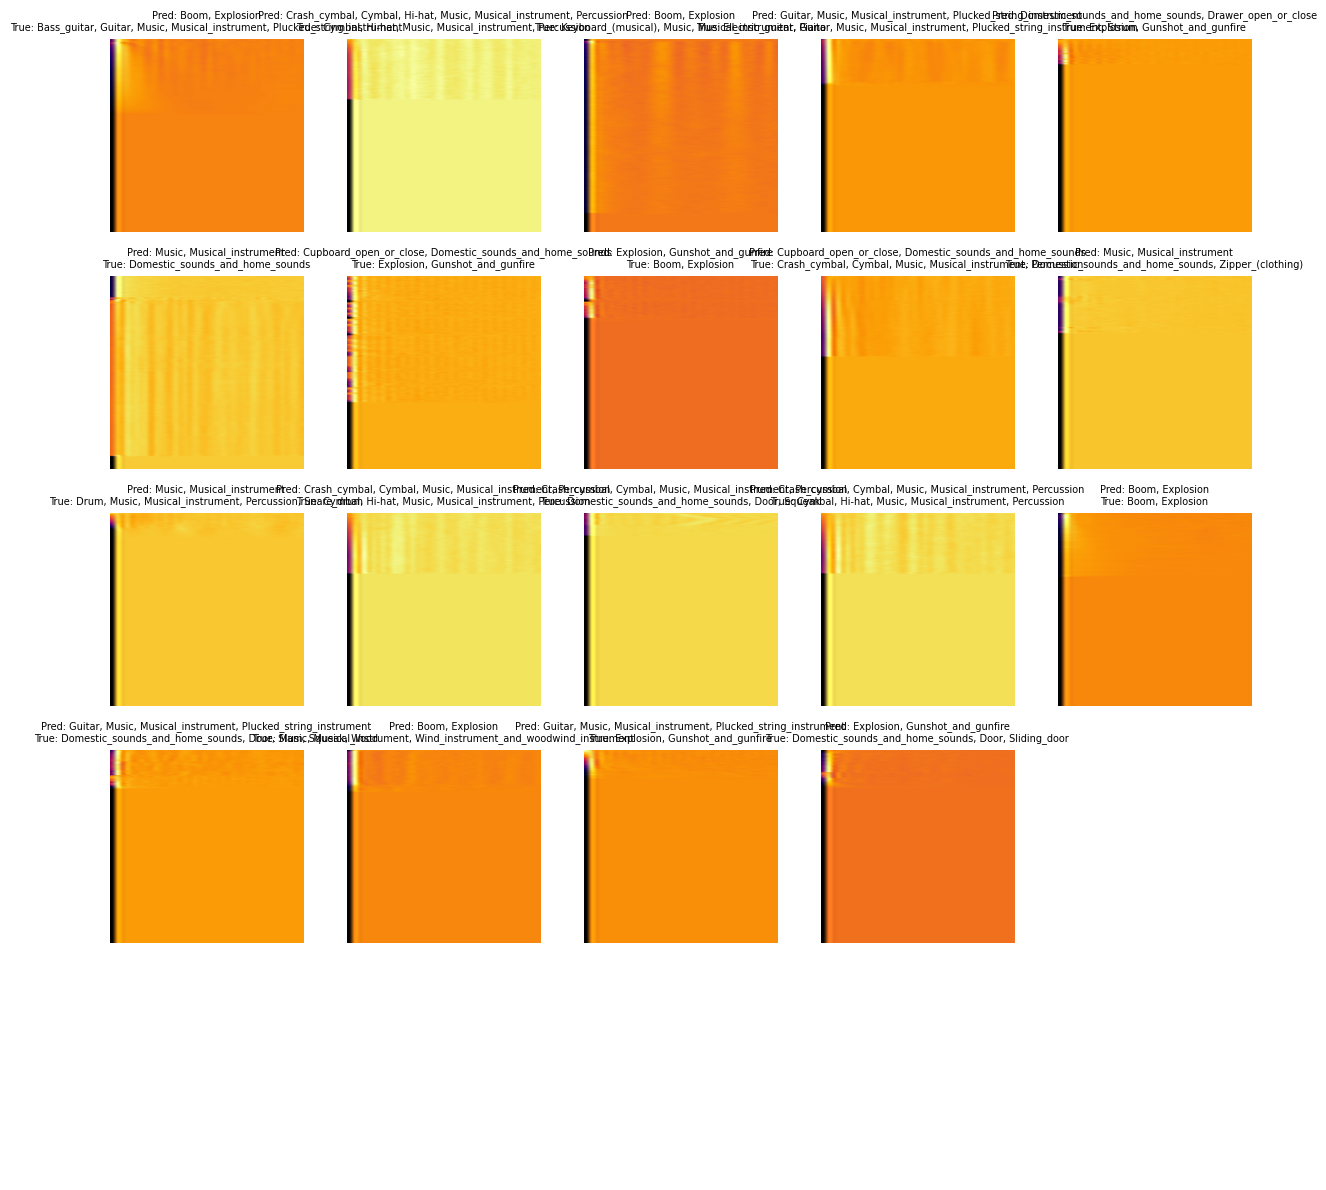

In [21]:
# prepare data for visualization
imgs = test_episode['query_data'].cpu().numpy().transpose(0, 2, 3, 1)
col_names = ['Accelerating_and_revving_and_vroom', 'Accordion', 'Acoustic_guitar', 'Aircraft', 'Alarm', 'Animal', 'Applause', 'Bark', 'Bass_drum', 'Bass_guitar', 'Bathtub_(filling_or_washing)', 'Bell', 'Bicycle', 'Bicycle_bell', 'Bird', 'Bird_vocalization_and_bird_call_and_bird_song', 'Boat_and_Water_vehicle', 'Boiling', 'Boom', 'Bowed_string_instrument', 'Brass_instrument', 'Breathing', 'Burping_and_eructation', 'Bus', 'Buzz', 'Camera', 'Car', 'Car_passing_by', 'Cat', 'Chatter', 'Cheering', 'Chewing_and_mastication', 'Chicken_and_rooster', 'Child_speech_and_kid_speaking', 'Chime', 'Chink_and_clink', 'Chirp_and_tweet', 'Chuckle_and_chortle', 'Church_bell', 'Clapping', 'Clock', 'Coin_(dropping)', 'Computer_keyboard', 'Conversation', 'Cough', 'Cowbell', 'Crack', 'Crackle', 'Crash_cymbal', 'Cricket', 'Crow', 'Crowd', 'Crumpling_and_crinkling', 'Crushing', 'Crying_and_sobbing', 'Cupboard_open_or_close', 'Cutlery_and_silverware', 'Cymbal', 'Dishes_and_pots_and_pans', 'Dog', 'Domestic_animals_and_pets', 'Domestic_sounds_and_home_sounds', 'Door', 'Doorbell', 'Drawer_open_or_close', 'Drill', 'Drip', 'Drum', 'Drum_kit', 'Electric_guitar', 'Engine', 'Engine_starting', 'Explosion', 'Fart', 'Female_singing', 'Female_speech_and_woman_speaking', 'Fill_(with_liquid)', 'Finger_snapping', 'Fire', 'Fireworks', 'Fixed-wing_aircraft_and_airplane', 'Fowl', 'Frog', 'Frying_(food)', 'Gasp', 'Giggle', 'Glass', 'Glockenspiel', 'Gong', 'Growling', 'Guitar', 'Gull_and_seagull', 'Gunshot_and_gunfire', 'Gurgling', 'Hammer', 'Hands', 'Harmonica', 'Harp', 'Hi-hat', 'Hiss', 'Human_group_actions', 'Human_voice', 'Idling', 'Insect', 'Keyboard_(musical)', 'Keys_jangling', 'Knock', 'Laughter', 'Liquid', 'Livestock_and_farm_animals_and_working_animals', 'Male_singing', 'Male_speech_and_man_speaking', 'Mallet_percussion', 'Marimba_and_xylophone', 'Mechanical_fan', 'Mechanisms', 'Meow', 'Microwave_oven', 'Motor_vehicle_(road)', 'Motorcycle', 'Music', 'Musical_instrument', 'Ocean', 'Organ', 'Packing_tape_and_duct_tape', 'Percussion', 'Piano', 'Plucked_string_instrument', 'Pour', 'Power_tool', 'Printer', 'Purr', 'Race_car_and_auto_racing', 'Rail_transport', 'Rain', 'Raindrop', 'Ratchet_and_pawl', 'Rattle', 'Rattle_(instrument)', 'Respiratory_sounds', 'Ringtone', 'Run', 'Sawing', 'Scissors', 'Scratching_(performance_technique)', 'Screaming', 'Screech', 'Shatter', 'Shout', 'Sigh', 'Singing', 'Sink_(filling_or_washing)', 'Siren', 'Skateboard', 'Slam', 'Sliding_door', 'Snare_drum', 'Sneeze', 'Speech', 'Speech_synthesizer', 'Splash_and_splatter', 'Squeak', 'Stream', 'Strum', 'Subway_and_metro_and_underground', 'Tabla', 'Tambourine', 'Tap', 'Tearing', 'Telephone', 'Thump_and_thud', 'Thunder', 'Thunderstorm', 'Tick', 'Tick-tock', 'Toilet_flush', 'Tools', 'Traffic_noise_and_roadway_noise', 'Train', 'Trickle_and_dribble', 'Truck', 'Trumpet', 'Typewriter', 'Typing', 'Vehicle', 'Vehicle_horn_and_car_horn_and_honking', 'Walk_and_footsteps', 'Water', 'Water_tap_and_faucet', 'Waves_and_surf', 'Whispering', 'Whoosh_and_swoosh_and_swish', 'Wild_animals', 'Wind', 'Wind_chime', 'Wind_instrument_and_woodwind_instrument', 'Wood', 'Writing', 'Yell', 'Zipper_(clothing)']

# prepare grid
grid_size = int(np.ceil(np.sqrt(imgs.shape[0])))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axes = axes.flatten()

for i in range(imgs.shape[0]):
    ax = axes[i]
    img = imgs[i]
    ax.imshow(img)
    ax.axis("off")
    active_indices = torch.nonzero(pred[i], as_tuple=True)[0]
    selected_labels = [col_names[i] for i in active_indices]

    # get query labels
    query_labels = torch.nonzero(test_episode['query_label'][i], as_tuple=True)[0]
    query_label_names = [col_names[i] for i in query_labels]

    ax.set_title(f"Pred: {', '.join(selected_labels)}\nTrue: {', '.join(query_label_names)}", fontsize=7)

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# get avg f1 in test set

checks = 200
running_f1 = 0.0
min_f1 = 2.0
max_f1 = -1.0
for i in tqdm(range(checks)):
  test_ep = test_dataset.getEpisode(6, 6, 6)
  _, f1 = predict(model, test_ep, device)
  min_f1 = min(min_f1, f1)
  max_f1 = max(max_f1, f1)
  running_f1 += f1

running_f1 = running_f1 / checks
print(f"Avg f1 in test set {running_f1:.2f}, min: {min_f1:.2f}, max: {max_f1:.2f}")